# Imports

In [1]:
import numpy as np
import pandas as pd 
import glob
import copy

import warnings
import joblib

from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
import gc
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.filterwarnings(action='ignore', category=UserWarning)
import os
import time
import random

In [2]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Config

In [3]:
folds = 10
seed_list = [i for i in range(20, 25)]
early_stopping = 50

In [4]:
train = pd.read_csv("D:/KaggleTabular/August/train.csv", index_col=0)
test = pd.read_csv("D:/KaggleTabular/August/test.csv").drop("id", axis = 1)
y = train.loss
X = train.drop(["loss"], axis = 1)

In [5]:
X.shape, y.shape

((250000, 100), (250000,))

# Optuna Tuning

In [10]:
import optuna

def objective(trial , X = X , y = y):
    
    params = {
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', 0.19, 0.5),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', 0.31, 0.34),
        'num_leaves' : trial.suggest_int('num_leaves', 50, 91),
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.01, 0.07),
        'max_depth' : trial.suggest_int('max_depth', 3 , 67),
        'n_estimators' : trial.suggest_int('n_estimators', 5555, 7000),
        'min_child_weight' : trial.suggest_loguniform('min_child_weight', 0.012, 0.04),
        'subsample' : trial.suggest_uniform('subsample', 0.789, 1.0),
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree', 0.52, 1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 76, 80),
        'metric' : 'rmse',
        'device_type' : 'gpu',
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse', valid_name = 'valid_0')  
    
    score = 0
    for seed in seed_list: 
        kf = KFold(n_splits = folds ,random_state= seed, shuffle=True)
        for idx_train,idx_test in kf.split(X, y):
            X_train,X_test=X.iloc[idx_train],X.iloc[idx_test]
            y_train,y_test=y.iloc[idx_train],y.iloc[idx_test]
            
            model = LGBMRegressor(**params, random_state = seed, n_jobs = -1)
            
            model.fit(
                X_train,
                y_train,
                eval_set = [(X_test , y_test)],
                eval_metric = 'rmse',
                early_stopping_rounds = early_stopping,
                verbose = 0, 
                callbacks = [pruning_callback]
            )
            
            y_pred = model.predict(X_test)  
            
            score += (rmse(y_test, y_pred) / folds) / len(seed_list)
            
    return score

In [11]:
study = optuna.create_study(direction = 'minimize',
                            study_name = 'lgbm',
                            sampler=optuna.samplers.TPESampler(),
                            pruner = optuna.pruners.HyperbandPruner())

[I 2021-08-01 16:49:23,229] A new study created in memory with name: lgbm


In [12]:
%%time
study.optimize(
    objective,
    timeout=3600*7.5,
    gc_after_trial=True
)

[I 2021-08-01 16:53:15,909] Trial 0 finished with value: 7.8537766726997225 and parameters: {'reg_alpha': 0.27947761573796387, 'reg_lambda': 0.32968190405991565, 'num_leaves': 70, 'learning_rate': 0.056719629827485324, 'max_depth': 67, 'n_estimators': 5781, 'min_child_weight': 0.027395340130487212, 'subsample': 0.8975524845048134, 'colsample_bytree': 0.7863318628962568, 'min_child_samples': 80}. Best is trial 0 with value: 7.8537766726997225.
[I 2021-08-01 16:55:28,580] Trial 1 finished with value: 7.852190611713889 and parameters: {'reg_alpha': 0.25026940971995765, 'reg_lambda': 0.3148535615133942, 'num_leaves': 59, 'learning_rate': 0.06702877987882784, 'max_depth': 39, 'n_estimators': 6503, 'min_child_weight': 0.02133117248096531, 'subsample': 0.9415192918547926, 'colsample_bytree': 0.5330768413449423, 'min_child_samples': 78}. Best is trial 1 with value: 7.852190611713889.
[I 2021-08-01 16:59:14,595] Trial 2 finished with value: 7.84950073294967 and parameters: {'reg_alpha': 0.47697

CPU times: user 31min 56s, sys: 32.2 s, total: 32min 28s
Wall time: 17min 28s


In [15]:
print('Finished Trials:' , len(study.trials))
print('Best Params:' , study.best_trial.params)
print('Best RMSE:' , study.best_value)

Finished Trials: 9
Best Params: {'reg_alpha': 0.4769722744188756, 'reg_lambda': 0.334061599522126, 'num_leaves': 90, 'learning_rate': 0.044949701791787484, 'max_depth': 65, 'n_estimators': 5606, 'min_child_weight': 0.03967086971827211, 'subsample': 0.9246803121468102, 'colsample_bytree': 0.6391707670912737, 'min_child_samples': 79}
Best RMSE: 7.84950073294967


In [17]:
params = study.best_trial.params

# Train Best Models

In [6]:
params = {
    'device':'cpu',
    'boosting_type':'gbdt',
    'metric':'rmse',
    'num_iterations':10000,
    'reg_alpha': 0.4289319768702188,
    'reg_lambda': 0.32373768916640583,
    'num_leaves': 72,
    'learning_rate': 0.04036898008526141,
    'max_depth': 44,
    'n_estimators': 6713,
    'min_child_weight': 0.014075875129886667,
    'subsample': 0.8092436815214556,
    'colsample_bytree': 0.5963038980389906,
    'min_child_samples': 78
}

In [7]:
show_feature_importance = 1
show_time = 1

score = 0
if show_feature_importance:
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    features = X.columns
    
for seed in seed_list: 
    kf = KFold(n_splits = folds, random_state=seed, shuffle=True)
    count = 1
    for idx_train,idx_test in kf.split(X, y):
        
        print("=" * 40)
        print("seed", seed)
        print("fold", count)
        print("=" * 40)
        
        if show_time:
            start_time = time.time()
        
        X_train, X_test = X.iloc[idx_train], X.iloc[idx_test]
        y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]
        
        model = LGBMRegressor(**params, random_state = seed)
        model.fit(X_train, y_train, eval_set = [(X_test , y_test.values.ravel())], eval_metric = 'rmse',\
                  early_stopping_rounds = early_stopping, verbose = False)
        
        cv_score = rmse(y_test.values.ravel(), model.predict(X_test))
        score += (cv_score / folds) / len(seed_list)
        
        joblib.dump(model, f'fold_models/LGBM seed_{seed}_fold_{count}_cv_score_{round(cv_score, 5)}.pkl') # save model
        
        if show_feature_importance:
            fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
            fold_importance_df['Feature']= features
            fold_importance_df['Importance']= model.feature_importances_
            fold_importance_df["fold"] = count
            features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
        if show_time:
            end_time = time.time()
            run_time = round(end_time - start_time)
            print ("fold", count, "took", run_time , "seconds to run")
            print ("The estimated remaining training time in the current seed", seed, "are", round(((folds - count) * run_time) / 60, 3), "minutes")        
        
        count += 1
        print("Validation score", cv_score)

print("Mean RMSPE validation score of", folds, "folds", score)

seed 20
fold 1
fold 1 took 8 seconds to run
The estimated remaining training time in the current seed 20 are 1.2 minutes
Validation score 7.809206175471103
seed 20
fold 2
fold 2 took 7 seconds to run
The estimated remaining training time in the current seed 20 are 0.933 minutes
Validation score 7.79111600995067
seed 20
fold 3
fold 3 took 6 seconds to run
The estimated remaining training time in the current seed 20 are 0.7 minutes
Validation score 7.9070163621722855
seed 20
fold 4
fold 4 took 6 seconds to run
The estimated remaining training time in the current seed 20 are 0.6 minutes
Validation score 7.8970518441622835
seed 20
fold 5
fold 5 took 7 seconds to run
The estimated remaining training time in the current seed 20 are 0.583 minutes
Validation score 7.85169467817502
seed 20
fold 6
fold 6 took 6 seconds to run
The estimated remaining training time in the current seed 20 are 0.4 minutes
Validation score 7.831558085537865
seed 20
fold 7
fold 7 took 7 seconds to run
The estimated re

In [8]:
# 7.847215777463001

In [9]:
if show_feature_importance:
    import seaborn as sns
    from matplotlib import pyplot as plt
    feature_importance_df_ = features_importance
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=True)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=True)[:10]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

Feature        object
Importance    float64
dtype: object


Feature        object
Importance    float64
dtype: object


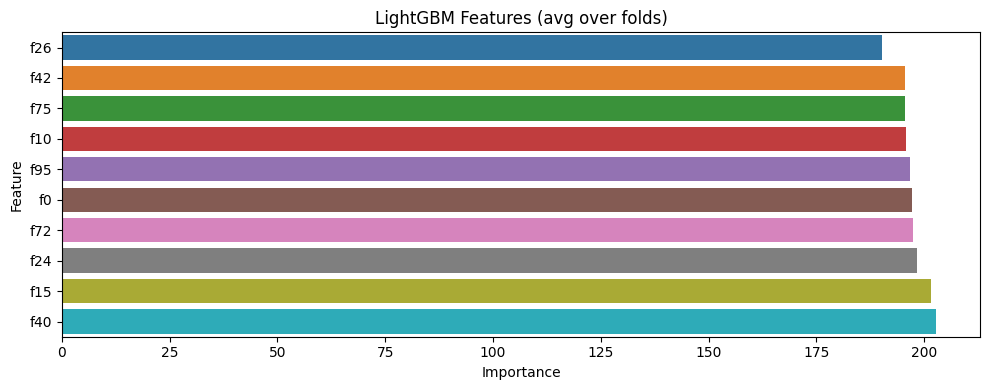

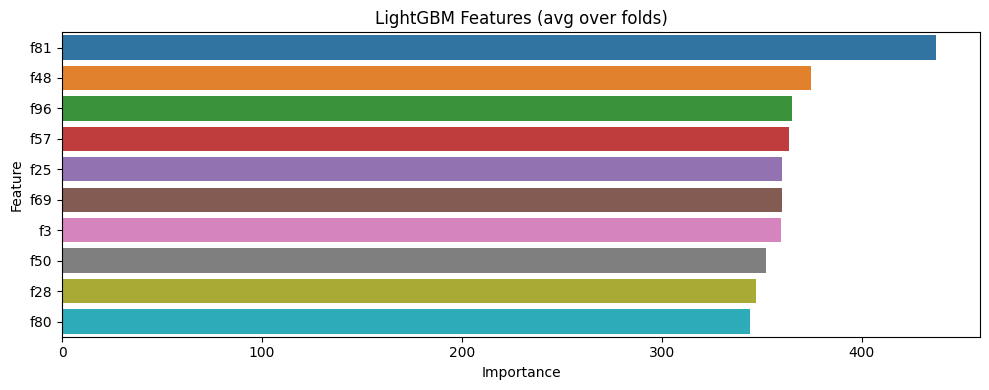

In [10]:
if show_feature_importance:
    feature_importance_df_ = features_importance
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending= False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10]
    best_features.reset_index(inplace=True)
    
    print(best_features.dtypes)
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [11]:
output = []
for filepath in glob.iglob('fold_models/*.pkl'):   
    model = joblib.load(filepath)
    pred = model.predict(test, num_iteration = model.best_iteration_)
    output.append(pred)
y_pred = sum(output) / len(output)

In [12]:
final_pred = pd.read_csv("D:/KaggleTabular/August/sample_submission.csv")
final_pred.loss = y_pred
final_pred

,id,loss
0,250000,7.501810
1,250001,4.886518
2,250002,7.973331
3,250003,7.334019
4,250004,7.344074
...,...,...
149995,399995,7.506733
149996,399996,7.139661
149997,399997,6.127911
149998,399998,5.706498


In [13]:
final_pred.to_csv('submission.csv', index=False)

In [14]:
# This code will submit the model to the competition if you have installed kaggle
!kaggle competitions submit -c tabular-playground-series-aug-2021 -f submission.csv -m "Optuna Tuned LightGBM Model"

Successfully submitted to Tabular Playground Series - Aug 2021



  0%|          | 0.00/3.72M [00:00<?, ?B/s]
  3%|2         | 104k/3.72M [00:00<00:03, 973kB/s]
 10%|#         | 384k/3.72M [00:00<00:01, 1.95MB/s]
 16%|#5        | 592k/3.72M [00:00<00:01, 2.02MB/s]
 24%|##4       | 928k/3.72M [00:00<00:01, 2.56MB/s]
 31%|###1      | 1.16M/3.72M [00:00<00:01, 2.37MB/s]
 37%|###7      | 1.39M/3.72M [00:00<00:01, 1.38MB/s]
 43%|####2     | 1.59M/3.72M [00:00<00:01, 1.53MB/s]
 49%|####9     | 1.84M/3.72M [00:01<00:01, 1.70MB/s]
 55%|#####4    | 2.04M/3.72M [00:01<00:00, 1.80MB/s]
 61%|######    | 2.25M/3.72M [00:01<00:00, 1.89MB/s]
 66%|######6   | 2.46M/3.72M [00:01<00:00, 1.96MB/s]
 72%|#######2  | 2.69M/3.72M [00:01<00:00, 1.99MB/s]
 78%|#######8  | 2.91M/3.72M [00:01<00:00, 2.06MB/s]
 84%|########3 | 3.12M/3.72M [00:01<00:00, 2.10MB/s]
 90%|########9 | 3.33M/3.72M [00:01<00:00, 2.12MB/s]
 95%|#########5| 3.54M/3.72M [00:01<00:00, 2.13MB/s]
100%|##########| 3.72M/3.72M [00:03<00:00, 1.11MB/s]
